In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import os
from datetime import datetime
import random
import string
import multiprocessing as mp
import itertools

In [2]:
import matplotlib.pyplot as plt
import timeit
%load_ext memory_profiler


In [3]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [4]:
REWARD = 100

In [5]:
seed = 741
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
XTRA_FEAT   = 1 #pole length
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]  +  XTRA_FEAT 
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [6]:
RNDM_STRING = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8)) + datetime.now().strftime("_%H_%M_%S")
print("ID: ",RNDM_STRING)
MODEL_FILENAME = './models/'+ RNDM_STRING + "_NN" + ".pt"
print("NN-MODEL FILENAME: ", MODEL_FILENAME)

ID:  HS78Q8CD_11_26_52
NN-MODEL FILENAME:  ./models/HS78Q8CD_11_26_52_NN.pt


In [7]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity[i]) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [8]:
def discretize(value, borders):
    c_pos_val, c_vel_val, p_ang_val, p_vel_val, length_val   = value
    c_pos_s  , c_vel_s  ,p_ang_s   , p_vel_s  , length_s     = borders
    
    indx = np.empty_like(value).astype(np.uint)
    
    for i in range(value.shape[0]):
        if value[i] > borders[i].max():
            indx[i] = borders[i].argmax()
        else:
            indx[i] = np.where(borders[i] >= value[i])[0][0].astype(np.uint)
    return indx



In [9]:
T_LR           = 1e-2
T_GAMMA        = 0.99
T_EPSILON      = 0.98

NO_OF_NODES    = 10
NO_OF_EPISODES = 100
TIMESTEP_LIMIT = 200

print("Number of NODES: ", NO_OF_NODES)
print("Number of EPISODES per NODE", NO_OF_EPISODES)

Number of NODES:  10
Number of EPISODES per NODE 100


In [10]:
# Hyper Parameters
HIDDEN_LAYER        = 50
BATCH_SIZE          = 32
NN_LR               = 1e-3  # learning rate
NN_GAMMA            = 0.9   # reward discount
TARGET_REPLACE_ITER = 500   # target update frequency
MIN_MEMORY_CAP      = 200000

In [11]:
MAX_NO_OF_ITERATIONS = 50
MAX_NN_ITERATIONS    = 50000
print("Number of ITERATIONS: ",MAX_NO_OF_ITERATIONS)

Number of ITERATIONS:  50


In [12]:
# class Net(nn.Module):
#     def __init__(self, ):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(N_STATES, 50)
#         nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
#         self.out = nn.Linear(50, N_ACTIONS)
#         nn.init.xavier_uniform_(self.out.weight)   # initialization

#     def forward(self, x):
#         x = self.fc1(x)
#         x = F.relu(x)
#         actions_value = self.out(x)
#         return actions_value

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()
    
class D3QN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter  = 0 # for target updating
        
        self.memory_counter      = 0
        self.memory              = np.zeros((int(MIN_MEMORY_CAP), N_STATES * 2 + 2)) # initialize memory
        
#         self.good_memory_counter = 0 # for storing non-terminal memories
#         self.good_memory         = np.zeros((MIN_MEMORY_CAP ,N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
#         self.bad_memory_counter  = 0 # for storing terminal memories
#         self.bad_memory          = np.zeros((MIN_MEMORY_CAP , N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        self.running_loss        = 0
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action
    
    def get_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions = self.eval_net.forward(x).view(-1,N_ACTIONS).max(1)[1].data.numpy().astype(np.intp)
#         actions_value 
#         action = torch.max(actions_value, 1)[1].data.numpy()
#         action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return actions
    
    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy().astype(np.float16)
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1
        
        sample_index_limit = min(MIN_MEMORY_CAP, self.memory_counter)
        sample_index = np.random.choice(int(sample_index_limit),int(BATCH_SIZE))
        b_memory = self.memory[sample_index,:]
#         # sample batch transitions
#         good_sample_index_limit = min(MIN_MEMORY_CAP, self.good_memory_counter)
#         bad_sample_index_limit = min(MIN_MEMORY_CAP, self.bad_memory_counter)

#         good_sample_index = np.random.choice(int(good_sample_index_limit), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
#         bad_sample_index  = np.random.choice(int(bad_sample_index_limit),  int(BATCH_SIZE*TERMINAL_BIAS))

#         b_good_memory = self.good_memory[good_sample_index, :]
#         b_bad_memory  = self.bad_memory[bad_sample_index, :]
#         b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.running_loss += loss.mean().item()
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            print('LOSS : %.3f' %(self.running_loss / TARGET_REPLACE_ITER), end="\t")
            self.running_loss = 0.0

In [13]:
def clamp(MIN_VAL, VAL, MAX_VAL):
    return max(MIN_VAL, min(VAL, MAX_VAL))

In [14]:
# ABSOLUTE LIMITS ON STATE VALUES
C_POS_ABS_MAX =  2.6
C_POS_ABS_MIN = -2.6

C_VEL_ABS_MAX =  5
C_VEL_ABS_MIN = -5

P_ANG_ABS_MAX =  0.25
P_ANG_ABS_MIN = -0.25

P_VEL_ABS_MAX =  6
P_VEL_ABS_MIN = -6

LENGTH_ABS_MAX = 0.725
LENGTH_ABS_MIN = 0.275

In [15]:
# SET GRANULARITY
HI_GRAIN = 40
LO_GRAIN = 4
print("HI_GRAIN = ", HI_GRAIN)
print("LO_GRAIN = ", LO_GRAIN)

HI_GRAIN =  40
LO_GRAIN =  4


In [16]:
def mp_node_run(node_id, boundary, iteration, p_table):

    # SET SEED
    ###############################################
    my_seed = seed + node_id + iteration
    random.seed(my_seed)
    torch.manual_seed(my_seed)
    np.random.seed(my_seed)
    os.environ['PYTHONHASHSEED'] = str(my_seed)
    my_env = env
    my_env.seed(my_seed)
    ###############################################
     # Mean values of pole length deviate from original value
    scaling_factor = 0.4 + (1.4 - 0.4) * (node_id + 1)/(NO_OF_NODES)
    ORIGNAL_LENGTH = 0.5    
    length_mean    = ORIGNAL_LENGTH * scaling_factor

    # SET STATE VALUE BORDERS
    ###############################################
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MIN, 
     C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MAX ]  = boundary
    
    
    # CREATE STATE TABLE BORDERS
    ###############################################
    c_pos_s  = np.linspace(C_POS_MIN,  C_POS_MAX,  HI_GRAIN)
    c_vel_s  = np.linspace(C_VEL_MIN,  C_VEL_MAX,  HI_GRAIN)
    p_ang_s  = np.linspace(P_ANG_MIN,  P_ANG_MAX,  HI_GRAIN)
    p_vel_s  = np.linspace(P_VEL_MIN,  P_VEL_MAX,  HI_GRAIN)
    length_s = np.linspace(LENGTH_MIN,  LENGTH_MAX, LO_GRAIN)

    my_borders = [c_pos_s, c_vel_s, p_ang_s, p_vel_s, length_s]
    ###############################################
    
    my_Q_TABLE = p_table
    time_rec                = np.zeros(NO_OF_EPISODES)
    level_up_flag           = False
    PERFECT_RUN_COUNTER     = 10
    PERFECT_RUNS_HIGH_SCORE = 10
    level_up_metric         = 195

    exp_rec      = np.empty(N_STATES * 2 + 2)
    
#     if iteration < 3:
    my_EPSILON   = np.clip(((3%5 + 1)*0.1 + (iteration)*0.2) ,0.4,0.98)+ np.random.uniform(-0.01,0.01)
#     print(node_id, my_EPSILON)
#     else:
#         my_EPSILON   = T_EPSILON + np.random.uniform(-0.01,0.01)
    
    while True:
        i_episode = 0
        
        while i_episode < NO_OF_EPISODES:
            ep_exp_rec = np.empty(N_STATES * 2 + 2)
            time_steps = 0
            
            my_env.length   = length_mean + np.random.uniform(-0.025,0.025)
            xtra = [my_env.length]
            
            s = my_env.reset()
            s = np.append(s, xtra)

            while True:
                time_steps += 1
                
                #get state
                this_state = tuple(discretize(s, my_borders))
                
                # choose action
                if np.random.uniform() > my_EPSILON:   # greedy
                    a = (node_id%N_ACTIONS)#np.random.randint(0, N_ACTIONS)
                else:
                    a = my_Q_TABLE[this_state]

                 # take action
                s_, r, done, info = my_env.step(a)
                s_ = np.append(s_, xtra)
                if done:
                    r = -REWARD
                    if time_steps >= TIMESTEP_LIMIT:
                        r = REWARD
                
                #store experience
                experience = np.hstack((s,a,r,s_))
                exp_rec = np.vstack((exp_rec, experience))

                #discretize next_state
                next_state = tuple(discretize(s_, my_borders))
                
                if done or time_steps >= TIMESTEP_LIMIT:
                    time_rec[i_episode] = time_steps
                    break
                s = s_

            i_episode += 1
        if i_episode >= NO_OF_EPISODES:
            i_episode = 0
            break

    exp_rec = np.delete(exp_rec, 0, 0)
#         message = "NODE#"+str(node_id) +" MAIN Q:"+ str(new_Q_TABLE.mean()) +"\t" + "NODE Q:" + str(my_Q_TABLE.mean())
#         print(message)

#     GET NEW STATE BOUNDARIES: +/- 25% of experienced state
    new_max = np.array([exp_rec[:,i].max() for i in range(N_STATES)])
    new_min = np.array([exp_rec[:,i].min() for i in range(N_STATES)])
    

    if iteration >= 4: 

        old_max = np.array(boundary[:N_STATES])
        old_min = np.array(boundary[N_STATES:])

        newboundary_max = old_max
        newboundary_min = old_min

        damper = 0.6
        for i in range(N_STATES):
            newboundary_max[i] = new_max[i] if new_max[i] >= old_max[i] else (old_max[i]*damper+new_max[i]*(1-damper))
            newboundary_min[i] = new_min[i] if new_min[i] <= old_min[i] else (old_min[i]*damper+new_min[i]*(1-damper))
            
            MARGIN = 2*(newboundary_max - newboundary_min)/HI_GRAIN

        newboundary = np.concatenate((newboundary_max + MARGIN,
                                      newboundary_min - MARGIN))
    else:
        MARGIN = 2*(new_max - new_min)/HI_GRAIN
        newboundary = np.concatenate((new_max + MARGIN,
                                      new_min + MARGIN))

        
#   # CLAMP STATE VALUE BORDERS
    ##############################################
    newboundary[0] = clamp(C_POS_ABS_MIN, newboundary[0], C_POS_ABS_MAX)
    newboundary[5] = clamp(C_POS_ABS_MIN, newboundary[5], C_POS_ABS_MAX) 

    newboundary[1] = clamp(C_VEL_ABS_MIN, newboundary[1], C_VEL_ABS_MAX)
    newboundary[6] = clamp(C_VEL_ABS_MIN, newboundary[6], C_VEL_ABS_MAX) 

    newboundary[2] = clamp(P_ANG_ABS_MIN, newboundary[2], P_ANG_ABS_MAX)
    newboundary[7] = clamp(P_ANG_ABS_MIN, newboundary[7], P_ANG_ABS_MAX) 

    newboundary[3] = clamp(P_VEL_ABS_MIN, newboundary[3], P_VEL_ABS_MAX)
    newboundary[8] = clamp(P_VEL_ABS_MIN, newboundary[8], P_VEL_ABS_MAX)
    
    newboundary[4] = clamp(LENGTH_ABS_MIN, newboundary[4], LENGTH_ABS_MAX)
    newboundary[9] = clamp(LENGTH_ABS_MIN, newboundary[9], LENGTH_ABS_MAX)
    
    return exp_rec, time_rec, newboundary

In [17]:
total_serial_timesteps   = 0
total_parallel_timesteps = 0

In [18]:
iteration = 0
# my_dqn = D3QN()
dqn = D3QN()

# INITIALIZE BOUNDARY TO MAXIMUM VALUES
init_node_boundary = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX,
                      C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN]



# CREATE STATE COMBINATIONS
# ###############################################

init_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN],
                                    [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX],
                                    [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN, LO_GRAIN*NO_OF_NODES  ])



# # GET Q-VALUES 
start = timeit.default_timer()
%memit init_q_table = dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN, LO_GRAIN*NO_OF_NODES).astype(np.intp)
stop = timeit.default_timer()
print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    
# SAVE QFILE
# node_QFILE = './Q_NPY/' + RNDM_STRING + 'QFILE' + ".npy"
# np.save(node_QFILE, init_q_table)

peak memory: 47606.10 MiB, increment: 43557.85 MiB
Quantization TIME:  0.39 minutes


In [19]:
# ENVIRONMENT FOR CHECKING NN MODEL
v_env = gym.make('CartPole-v0')
v_env.seed(seed*2)

# CREATE A POOL OF PROCESSES
pool = mp.Pool(NO_OF_NODES)

# SET INITIAL NODE BOUDNARIES FOR ALL NODES
node_boundaries = [init_node_boundary] * NO_OF_NODES
node_q_table = init_q_table
q_table_list = [node_q_table]* NO_OF_NODES




ITERATION # 0
TOTAL EXPERIENCE GENERATED:   11787
SMALLEST TIMESTEP: 8
LARGEST  TIMESTEP: 38
TOTAL SERIAL TIMESTEPS:   11787
TOTAL PARALLEL TIMESTEPS: 38


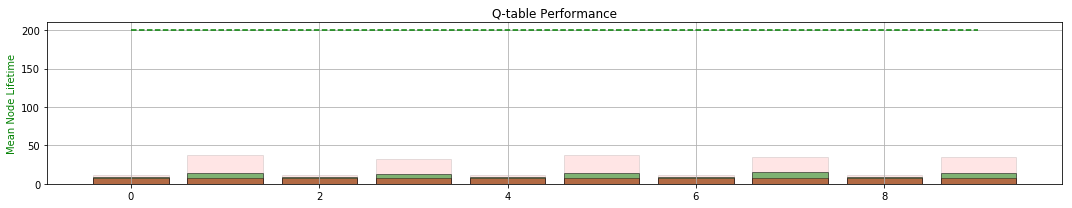

MEMORY COUNTER:  11787
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 694.509	LOSS : 636.825	LOSS : 587.847	LOSS : 582.660	LOSS : 589.108	LOSS : 545.882	LOSS : 538.406	LOSS : 543.363	LOSS : 534.949	LOSS : 528.705	LOSS : 534.742	LOSS : 527.907	LOSS : 515.578	LOSS : 517.877	LOSS : 487.438	LOSS : 502.990	LOSS : 483.576	LOSS : 489.158	LOSS : 474.649	LOSS : 467.093	
Validating... MEAN TIME:  88.31
LOSS : 481.353	LOSS : 459.803	LOSS : 448.976	LOSS : 438.010	LOSS : 431.322	LOSS : 447.308	LOSS : 433.361	LOSS : 424.541	LOSS : 424.743	LOSS : 424.786	LOSS : 398.578	LOSS : 402.717	LOSS : 409.060	LOSS : 408.990	LOSS : 384.977	LOSS : 401.730	LOSS : 386.433	LOSS : 395.015	LOSS : 382.921	LOSS : 386.341	
Validating... MEAN TIME:  129.655
LOSS : 392.834	LOSS : 383.665	LOSS : 381.745	LOSS : 384.672	LOSS : 383.175	LOSS : 390.497	LOSS : 380.925	LOSS : 370.093	LOSS : 374.805	LOSS : 380.966	LOSS : 373.734	LOSS : 361.030	LOSS : 364.213	LOSS : 375.851	LOSS : 367.114	LOSS : 356.530	LOSS : 359

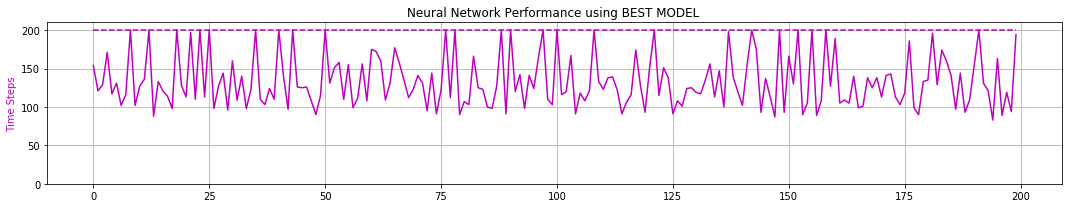

0 -max- [ 0.062  0.151  0.222  3.120  0.277]
0 -min- [-0.208 -1.864 -0.036  0.102  0.275]

peak memory: 47968.96 MiB, increment: 43103.80 MiB
Quantization TIME:  0.39 minutes
1 -max- [ 0.303  3.145  0.230  2.340  0.327]
1 -min- [-0.182 -1.137 -0.188 -3.207  0.278]

peak memory: 49244.38 MiB, increment: 43598.46 MiB
Quantization TIME:  0.4 minutes
2 -max- [ 0.063  0.147  0.221  3.084  0.377]
2 -min- [-0.198 -1.806 -0.035  0.101  0.328]

peak memory: 50034.02 MiB, increment: 43606.89 MiB
Quantization TIME:  0.4 minutes
3 -max- [ 0.287  2.698  0.230  2.242  0.427]
3 -min- [-0.176 -1.030 -0.188 -3.009  0.378]

peak memory: 50956.56 MiB, increment: 43748.20 MiB
Quantization TIME:  0.4 minutes
4 -max- [ 0.062  0.148  0.222  3.107  0.477]
4 -min- [-0.201 -1.869 -0.037  0.102  0.428]

peak memory: 51648.16 MiB, increment: 43658.59 MiB
Quantization TIME:  0.4 minutes
5 -max- [ 0.325  3.031  0.230  2.098  0.527]
5 -min- [-0.179 -0.826 -0.188 -3.112  0.478]

peak memory: 52519.47 MiB, increment: 

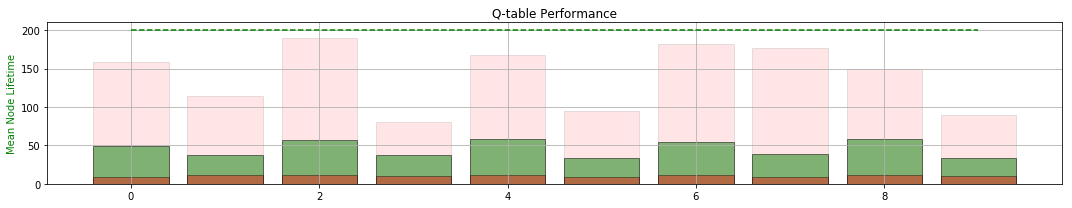

MEMORY COUNTER:  57556
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 490.908	LOSS : 502.596	LOSS : 514.738	LOSS : 488.595	LOSS : 476.572	LOSS : 460.949	LOSS : 414.528	LOSS : 397.032	LOSS : 377.990	LOSS : 378.957	LOSS : 344.297	LOSS : 342.876	LOSS : 338.343	LOSS : 315.628	LOSS : 321.731	LOSS : 305.352	LOSS : 314.582	LOSS : 308.193	LOSS : 296.711	LOSS : 300.349	
Validating... MEAN TIME:  171.765
LOSS : 290.965	LOSS : 296.488	LOSS : 299.846	LOSS : 298.404	LOSS : 292.077	LOSS : 287.349	LOSS : 267.394	LOSS : 290.248	LOSS : 283.145	LOSS : 277.845	LOSS : 285.616	LOSS : 288.549	LOSS : 279.810	LOSS : 292.322	LOSS : 296.422	LOSS : 284.350	LOSS : 283.917	LOSS : 284.999	LOSS : 281.234	LOSS : 294.536	
Validating... MEAN TIME:  178.815
LOSS : 279.969	LOSS : 289.786	LOSS : 300.535	LOSS : 292.544	LOSS : 280.502	LOSS : 279.277	LOSS : 276.793	LOSS : 288.622	LOSS : 273.502	LOSS : 283.318	LOSS : 283.383	LOSS : 285.761	LOSS : 298.293	LOSS : 282.716	LOSS : 303.117	LOSS : 286.976	LOSS : 2

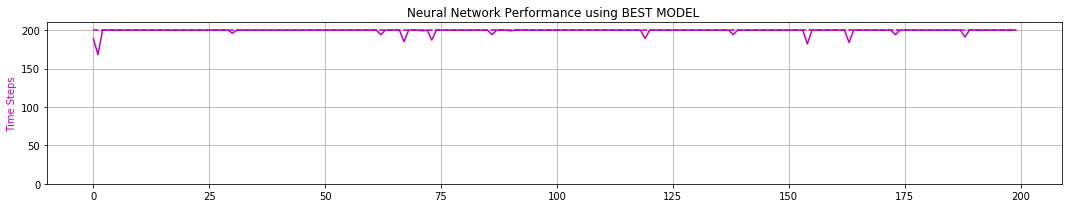

0 -max- [ 0.799  2.025  0.230  2.758  0.277]
0 -min- [-0.553 -1.392 -0.187 -1.591  0.275]

peak memory: 56376.82 MiB, increment: 43738.24 MiB
Quantization TIME:  0.63 minutes
1 -max- [ 0.259  1.742  0.062  1.221  0.327]
1 -min- [-0.506 -1.196 -0.196 -2.298  0.278]

peak memory: 57156.54 MiB, increment: 43742.89 MiB
Quantization TIME:  0.61 minutes
2 -max- [ 0.781  1.873  0.230  2.899  0.376]
2 -min- [-1.303 -1.528 -0.188 -1.716  0.328]

peak memory: 57935.44 MiB, increment: 43743.18 MiB
Quantization TIME:  0.56 minutes
3 -max- [ 0.322  1.538  0.063  1.149  0.427]
3 -min- [-0.502 -1.200 -0.196 -2.088  0.379]

peak memory: 58659.45 MiB, increment: 43685.47 MiB
Quantization TIME:  0.57 minutes
4 -max- [ 0.933  2.260  0.230  2.967  0.477]
4 -min- [-0.765 -1.742 -0.188 -1.929  0.428]

peak memory: 59472.77 MiB, increment: 43720.68 MiB
Quantization TIME:  0.57 minutes
5 -max- [ 0.248  1.512  0.062  1.178  0.527]
5 -min- [-0.492 -1.207 -0.196 -2.045  0.479]

peak memory: 60283.64 MiB, increme

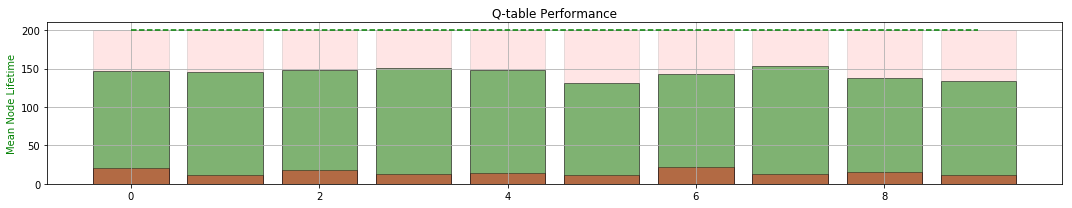

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 251.454	LOSS : 247.389	LOSS : 215.369	LOSS : 198.860	LOSS : 209.714	LOSS : 207.299	LOSS : 189.486	LOSS : 196.428	LOSS : 202.946	LOSS : 178.072	LOSS : 170.145	LOSS : 177.653	LOSS : 189.473	LOSS : 175.836	LOSS : 185.452	LOSS : 174.879	LOSS : 171.071	LOSS : 172.907	LOSS : 153.001	LOSS : 165.322	
Validating... MEAN TIME:  200.0
LOSS : 163.063	LOSS : 178.458	LOSS : 171.003	LOSS : 149.040	LOSS : 152.827	LOSS : 165.891	LOSS : 160.244	LOSS : 162.299	LOSS : 163.471	LOSS : 152.409	LOSS : 158.731	LOSS : 159.513	LOSS : 153.280	LOSS : 161.450	LOSS : 149.789	LOSS : 152.880	LOSS : 167.401	LOSS : 150.746	LOSS : 146.745	LOSS : 169.095	
Validating... MEAN TIME:  200.0
LOSS : 160.999	LOSS : 145.477	LOSS : 152.744	LOSS : 145.735	LOSS : 146.303	LOSS : 147.012	LOSS : 171.636	LOSS : 165.496	LOSS : 154.306	LOSS : 168.770	LOSS : 149.820	LOSS : 156.885	LOSS : 158.828	LOSS : 149.694	LOSS : 162.178	LOSS : 153.468	LOSS : 173.

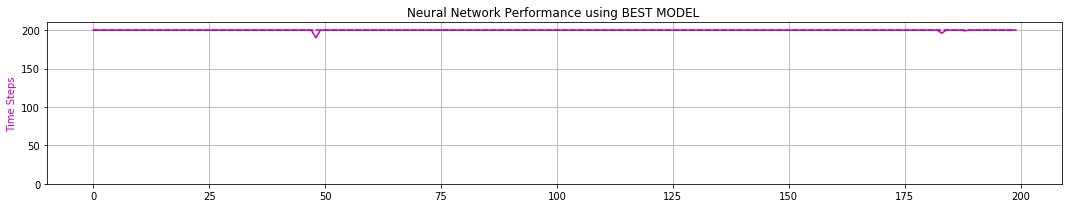

0 -max- [ 2.456  2.897  0.226  2.859  0.276]
0 -min- [-0.995 -1.506 -0.113 -1.694  0.275]

peak memory: 56089.47 MiB, increment: 43399.66 MiB
Quantization TIME:  0.4 minutes
1 -max- [ 0.297  1.399  0.092  1.691  0.327]
1 -min- [-2.271 -2.326 -0.195 -1.806  0.278]

peak memory: 57091.83 MiB, increment: 43620.78 MiB
Quantization TIME:  0.41 minutes
2 -max- [ 2.563  3.050  0.226  2.545  0.377]
2 -min- [-0.877 -1.381 -0.113 -1.496  0.328]

peak memory: 57790.37 MiB, increment: 43538.10 MiB
Quantization TIME:  0.4 minutes
3 -max- [ 0.281  1.382  0.082  1.844  0.426]
3 -min- [-2.272 -2.185 -0.196 -2.046  0.377]

peak memory: 58741.07 MiB, increment: 43707.32 MiB
Quantization TIME:  0.4 minutes
4 -max- [ 1.997  2.628  0.226  2.557  0.476]
4 -min- [-1.270 -1.349 -0.106 -1.507  0.428]

peak memory: 59381.57 MiB, increment: 43566.60 MiB
Quantization TIME:  0.41 minutes
5 -max- [ 0.343  1.540  0.094  1.823  0.527]
5 -min- [-2.268 -2.223 -0.195 -1.824  0.478]

peak memory: 59952.23 MiB, increment:

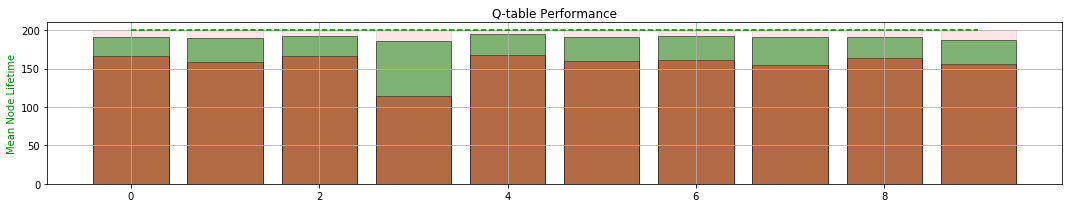

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 85.520	LOSS : 92.159	LOSS : 70.102	LOSS : 69.483	LOSS : 59.835	LOSS : 70.718	LOSS : 58.699	LOSS : 66.808	LOSS : 63.257	LOSS : 58.826	LOSS : 63.277	LOSS : 54.183	LOSS : 53.422	LOSS : 56.791	LOSS : 50.263	LOSS : 55.361	LOSS : 57.341	LOSS : 61.631	LOSS : 45.910	LOSS : 56.799	
Validating... MEAN TIME:  188.635
LOSS : 50.035	LOSS : 61.843	LOSS : 54.109	LOSS : 43.341	LOSS : 52.953	LOSS : 52.002	LOSS : 55.722	LOSS : 45.857	LOSS : 60.357	LOSS : 53.558	LOSS : 54.671	LOSS : 50.084	LOSS : 55.736	LOSS : 50.892	LOSS : 57.967	LOSS : 58.413	LOSS : 58.454	LOSS : 62.961	LOSS : 51.843	LOSS : 40.620	
Validating... MEAN TIME:  166.575
LOSS : 53.696	LOSS : 63.650	LOSS : 46.487	LOSS : 52.269	LOSS : 56.239	LOSS : 57.038	LOSS : 64.031	LOSS : 51.319	LOSS : 52.581	LOSS : 53.875	LOSS : 54.881	LOSS : 53.942	LOSS : 48.943	LOSS : 50.876	LOSS : 52.051	LOSS : 59.564	LOSS : 55.475	LOSS : 59.496	LOSS : 55.393	LOSS : 51.995	
Valida

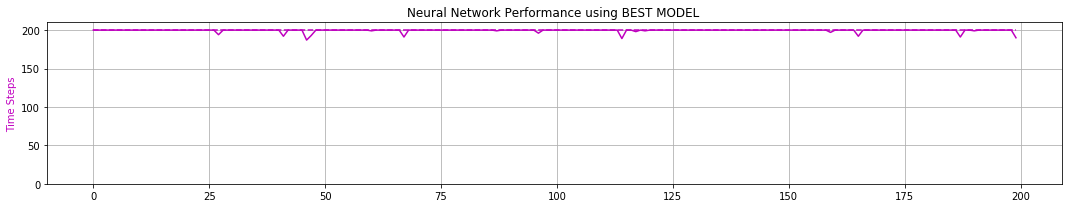

0 -max- [ 0.372  1.377  0.190  1.829  0.277]
0 -min- [-2.268 -2.244 -0.184 -1.417  0.275]

peak memory: 56406.11 MiB, increment: 43696.86 MiB
Quantization TIME:  0.41 minutes
1 -max- [ 0.258  1.115  0.119  1.775  0.327]
1 -min- [-2.273 -2.257 -0.193 -1.365  0.278]

peak memory: 56709.79 MiB, increment: 43219.38 MiB
Quantization TIME:  0.41 minutes
2 -max- [ 1.370  1.560  0.201  1.810  0.377]
2 -min- [-2.220 -2.235 -0.184 -1.470  0.328]

peak memory: 57495.38 MiB, increment: 43224.00 MiB
Quantization TIME:  0.41 minutes
3 -max- [ 0.365  1.178  0.124  1.787  0.427]
3 -min- [-2.268 -2.249 -0.193 -1.423  0.378]

peak memory: 58289.11 MiB, increment: 43236.51 MiB
Quantization TIME:  0.41 minutes
4 -max- [ 0.262  1.359  0.175  1.954  0.477]
4 -min- [-2.273 -2.244 -0.183 -1.410  0.428]

peak memory: 59134.23 MiB, increment: 43300.40 MiB
Quantization TIME:  0.41 minutes
5 -max- [ 0.269  0.998  0.125  1.754  0.527]
5 -min- [-2.273 -2.261 -0.190 -1.316  0.479]

peak memory: 60349.69 MiB, increme

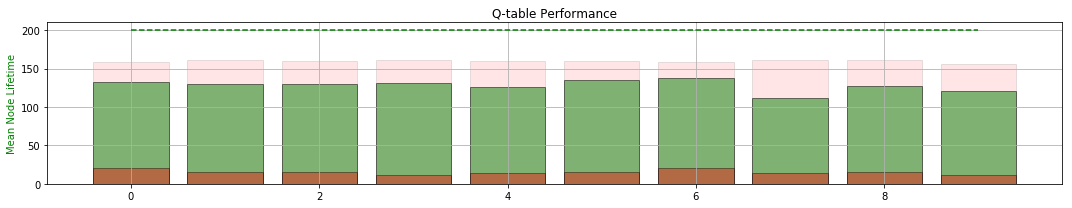

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 65.318	LOSS : 72.877	LOSS : 68.471	LOSS : 73.818	LOSS : 63.837	LOSS : 65.568	LOSS : 62.815	LOSS : 64.922	LOSS : 58.196	LOSS : 74.394	LOSS : 73.439	LOSS : 62.136	LOSS : 65.914	LOSS : 56.950	LOSS : 76.147	LOSS : 69.623	LOSS : 63.000	LOSS : 61.068	LOSS : 64.443	LOSS : 68.376	
Validating... MEAN TIME:  123.665
LOSS : 66.129	LOSS : 58.304	LOSS : 69.612	LOSS : 68.109	LOSS : 67.551	LOSS : 65.734	LOSS : 70.742	LOSS : 70.319	LOSS : 57.470	LOSS : 52.385	LOSS : 66.872	LOSS : 65.929	LOSS : 67.107	LOSS : 63.690	LOSS : 65.275	LOSS : 64.128	LOSS : 64.438	LOSS : 65.034	LOSS : 68.496	LOSS : 69.512	
Validating... MEAN TIME:  134.675
LOSS : 77.246	LOSS : 57.382	LOSS : 71.641	LOSS : 66.073	LOSS : 66.716	LOSS : 54.818	LOSS : 62.930	LOSS : 70.502	LOSS : 69.543	LOSS : 58.545	LOSS : 60.882	LOSS : 57.930	LOSS : 76.248	LOSS : 54.739	LOSS : 64.195	LOSS : 63.797	LOSS : 62.423	LOSS : 70.827	LOSS : 69.348	LOSS : 59.241	
Valida

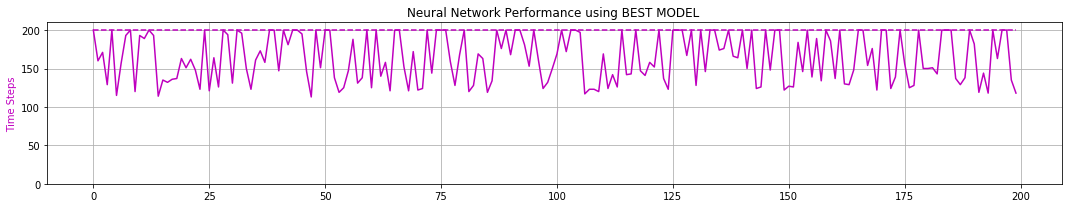

0 -max- [ 1.842  3.626  0.249  4.692  0.561]
0 -min- [-2.600 -4.330 -0.250 -4.689  0.275]

peak memory: 59990.54 MiB, increment: 43333.27 MiB
Quantization TIME:  0.4 minutes
1 -max- [ 1.838  3.771  0.235  4.677  0.579]
1 -min- [-2.600 -4.383 -0.250 -4.661  0.275]

peak memory: 60854.64 MiB, increment: 43416.16 MiB
Quantization TIME:  0.41 minutes
2 -max- [ 1.847  3.698  0.241  4.762  0.599]
2 -min- [-2.600 -4.396 -0.250 -4.683  0.281]

peak memory: 61456.53 MiB, increment: 43236.57 MiB
Quantization TIME:  0.4 minutes
3 -max- [ 1.841  3.779  0.235  4.675  0.619]
3 -min- [-2.600 -4.408 -0.250 -4.670  0.301]

peak memory: 62074.54 MiB, increment: 43073.35 MiB
Quantization TIME:  0.41 minutes
4 -max- [ 1.843  3.621  0.245  4.679  0.639]
4 -min- [-2.600 -4.404 -0.250 -4.686  0.321]

peak memory: 63511.66 MiB, increment: 43729.25 MiB
Quantization TIME:  0.41 minutes
5 -max- [ 1.843  3.755  0.236  4.811  0.659]
5 -min- [-2.600 -4.334 -0.250 -4.692  0.341]

peak memory: 64150.55 MiB, increment

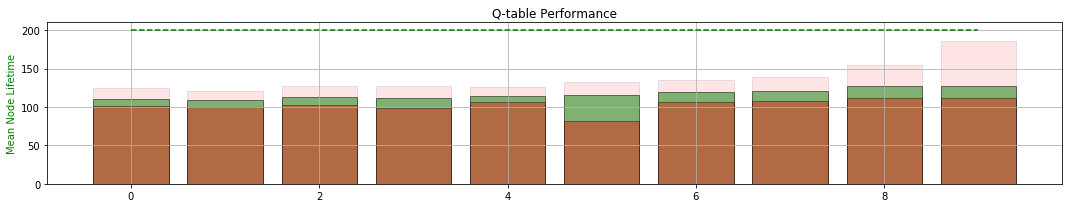

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 76.748	LOSS : 80.940	LOSS : 83.692	LOSS : 84.390	LOSS : 84.746	LOSS : 75.553	LOSS : 76.071	LOSS : 77.363	LOSS : 72.723	LOSS : 77.437	LOSS : 74.594	LOSS : 78.351	LOSS : 79.032	LOSS : 79.005	LOSS : 80.907	LOSS : 76.067	LOSS : 74.408	LOSS : 79.678	LOSS : 73.489	LOSS : 79.546	
Validating... MEAN TIME:  84.05
LOSS : 79.473	LOSS : 69.908	LOSS : 77.807	LOSS : 70.697	LOSS : 62.319	LOSS : 73.076	LOSS : 74.558	LOSS : 70.678	LOSS : 77.132	LOSS : 72.047	LOSS : 78.936	LOSS : 76.769	LOSS : 79.968	LOSS : 79.541	LOSS : 68.527	LOSS : 74.513	LOSS : 63.830	LOSS : 75.664	LOSS : 75.669	LOSS : 66.148	
Validating... MEAN TIME:  74.45
LOSS : 68.977	LOSS : 64.807	LOSS : 73.999	LOSS : 68.114	LOSS : 68.796	LOSS : 70.729	LOSS : 69.770	LOSS : 58.285	LOSS : 72.143	LOSS : 74.961	LOSS : 64.511	LOSS : 65.590	LOSS : 70.460	LOSS : 69.672	LOSS : 62.314	LOSS : 70.824	LOSS : 72.657	LOSS : 66.386	LOSS : 69.514	LOSS : 68.111	
Validating

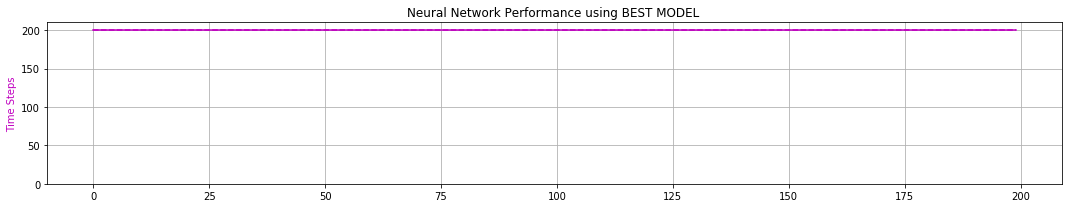

0 -max- [ 1.339  2.743  0.189  3.551  0.457]
0 -min- [-2.600 -4.177 -0.243 -3.497  0.275]

peak memory: 60205.95 MiB, increment: 43598.72 MiB
Quantization TIME:  0.41 minutes
1 -max- [ 1.341  2.905  0.180  3.664  0.488]
1 -min- [-2.600 -4.291 -0.250 -3.583  0.275]

peak memory: 60646.23 MiB, increment: 43257.52 MiB
Quantization TIME:  0.41 minutes
2 -max- [ 1.346  2.846  0.184  3.608  0.520]
2 -min- [-2.600 -4.225 -0.239 -3.567  0.288]

peak memory: 61855.96 MiB, increment: 43686.03 MiB
Quantization TIME:  0.41 minutes
3 -max- [ 1.341  2.843  0.181  3.544  0.552]
3 -min- [-2.600 -4.230 -0.250 -3.500  0.320]

peak memory: 62398.09 MiB, increment: 43446.93 MiB
Quantization TIME:  0.41 minutes
4 -max- [ 1.346  2.741  0.187  3.538  0.584]
4 -min- [-2.600 -4.201 -0.240 -3.488  0.352]

peak memory: 63428.40 MiB, increment: 43696.02 MiB
Quantization TIME:  0.41 minutes
5 -max- [ 1.338  2.896  0.181  3.631  0.616]
5 -min- [-2.600 -4.188 -0.250 -3.622  0.384]

peak memory: 64032.59 MiB, increme

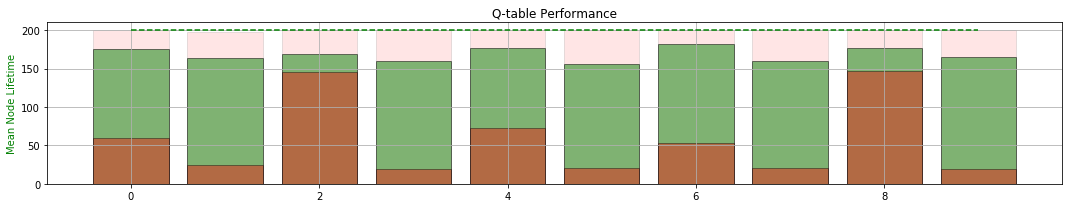

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 71.329	LOSS : 65.304	LOSS : 61.202	LOSS : 65.578	LOSS : 60.742	LOSS : 63.831	LOSS : 61.238	LOSS : 55.480	LOSS : 60.567	LOSS : 61.740	LOSS : 55.628	LOSS : 60.242	LOSS : 60.396	LOSS : 59.479	LOSS : 54.524	LOSS : 63.640	LOSS : 50.654	LOSS : 68.164	LOSS : 51.253	LOSS : 49.285	
Validating... MEAN TIME:  191.685
LOSS : 60.160	LOSS : 61.767	LOSS : 59.274	LOSS : 65.725	LOSS : 59.377	LOSS : 64.906	LOSS : 64.932	LOSS : 62.102	LOSS : 64.552	LOSS : 70.246	LOSS : 67.622	LOSS : 66.698	LOSS : 67.524	LOSS : 67.437	LOSS : 69.223	LOSS : 69.356	LOSS : 62.668	LOSS : 68.358	LOSS : 79.164	LOSS : 65.887	
Validating... MEAN TIME:  109.055
LOSS : 70.285	LOSS : 67.817	LOSS : 64.159	LOSS : 68.497	LOSS : 59.498	LOSS : 81.868	LOSS : 68.542	LOSS : 59.378	LOSS : 68.727	LOSS : 74.329	LOSS : 72.297	LOSS : 71.073	LOSS : 63.364	LOSS : 72.474	LOSS : 73.805	LOSS : 77.752	LOSS : 67.015	LOSS : 72.120	LOSS : 77.524	LOSS : 61.743	
Valida

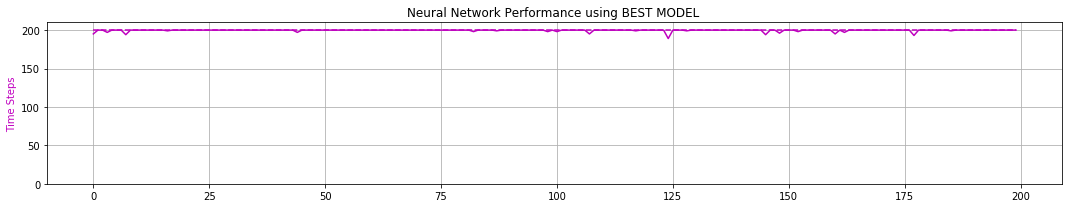

0 -max- [ 1.047  2.094  0.229  3.235  0.392]
0 -min- [-2.600 -3.850 -0.248 -2.811  0.275]

peak memory: 59941.91 MiB, increment: 43284.02 MiB
Quantization TIME:  0.41 minutes
1 -max- [ 1.041  2.273  0.200  3.308  0.430]
1 -min- [-2.600 -3.929 -0.250 -2.865  0.275]

peak memory: 60696.32 MiB, increment: 43257.52 MiB
Quantization TIME:  0.41 minutes
2 -max- [ 1.042  2.160  0.220  3.256  0.470]
2 -min- [-2.600 -3.883 -0.247 -2.868  0.295]

peak memory: 61923.47 MiB, increment: 43703.45 MiB
Quantization TIME:  0.41 minutes
3 -max- [ 1.047  2.227  0.203  3.201  0.509]
3 -min- [-2.600 -3.943 -0.250 -2.817  0.334]

peak memory: 62490.35 MiB, increment: 43489.11 MiB
Quantization TIME:  0.41 minutes
4 -max- [ 1.043  2.091  0.228  3.196  0.548]
4 -min- [-2.600 -3.865 -0.249 -2.792  0.373]

peak memory: 63204.43 MiB, increment: 43421.96 MiB
Quantization TIME:  0.4 minutes
5 -max- [ 1.046  2.266  0.201  3.276  0.587]
5 -min- [-2.600 -3.918 -0.250 -2.942  0.413]

peak memory: 64048.50 MiB, incremen

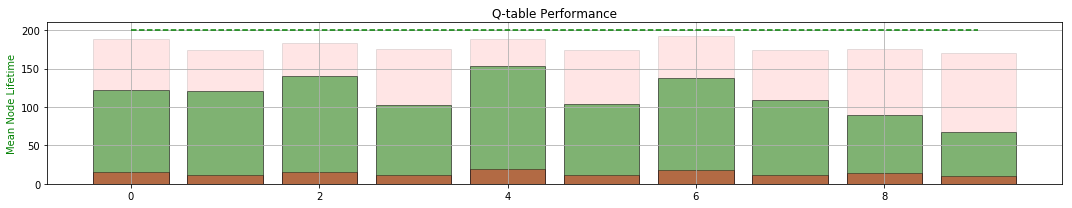

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 96.481	LOSS : 78.496	LOSS : 85.475	LOSS : 75.636	LOSS : 74.160	LOSS : 83.522	LOSS : 73.250	LOSS : 77.591	LOSS : 64.013	LOSS : 72.263	LOSS : 60.753	LOSS : 71.671	LOSS : 78.922	LOSS : 83.519	LOSS : 68.928	LOSS : 72.230	LOSS : 74.032	LOSS : 79.578	LOSS : 66.559	LOSS : 73.565	
Validating... MEAN TIME:  200.0
LOSS : 71.721	LOSS : 74.304	LOSS : 66.620	LOSS : 64.992	LOSS : 72.963	LOSS : 62.380	LOSS : 75.333	LOSS : 66.244	LOSS : 66.900	LOSS : 75.278	LOSS : 64.735	LOSS : 75.993	LOSS : 66.905	LOSS : 67.501	LOSS : 65.400	LOSS : 65.789	LOSS : 71.072	LOSS : 68.494	LOSS : 63.809	LOSS : 69.148	
Validating... MEAN TIME:  200.0
LOSS : 58.948	LOSS : 71.484	LOSS : 85.058	LOSS : 73.709	LOSS : 72.213	LOSS : 63.569	LOSS : 73.235	LOSS : 68.974	LOSS : 71.593	LOSS : 62.207	LOSS : 72.628	LOSS : 65.608	LOSS : 69.374	LOSS : 60.033	LOSS : 67.026	LOSS : 67.553	LOSS : 69.160	LOSS : 63.967	LOSS : 67.569	LOSS : 55.616	
Validating

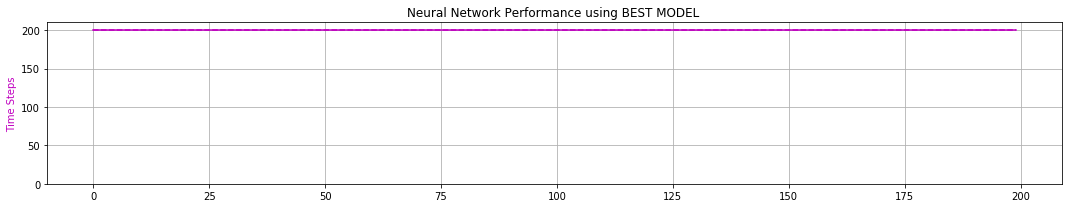

0 -max- [ 0.871  1.988  0.242  2.903  0.351]
0 -min- [-2.600 -3.405 -0.250 -2.738  0.275]

peak memory: 60224.34 MiB, increment: 43617.62 MiB
Quantization TIME:  0.4 minutes
1 -max- [ 0.865  2.104  0.214  2.950  0.393]
1 -min- [-2.600 -3.448 -0.250 -2.769  0.275]

peak memory: 60645.41 MiB, increment: 43257.52 MiB
Quantization TIME:  0.41 minutes
2 -max- [ 0.867  2.026  0.227  2.927  0.438]
2 -min- [-2.600 -3.416 -0.250 -2.785  0.301]

peak memory: 61832.11 MiB, increment: 43663.00 MiB
Quantization TIME:  0.4 minutes
3 -max- [ 0.871  2.074  0.214  2.923  0.482]
3 -min- [-2.600 -3.517 -0.250 -2.823  0.344]

peak memory: 62160.93 MiB, increment: 43210.33 MiB
Quantization TIME:  0.41 minutes
4 -max- [ 0.870  1.984  0.243  2.959  0.525]
4 -min- [-2.600 -3.464 -0.250 -2.725  0.388]

peak memory: 63197.63 MiB, increment: 43465.55 MiB
Quantization TIME:  0.41 minutes
5 -max- [ 0.860  2.147  0.213  3.011  0.569]
5 -min- [-2.600 -3.592 -0.250 -2.903  0.432]

peak memory: 63801.71 MiB, increment

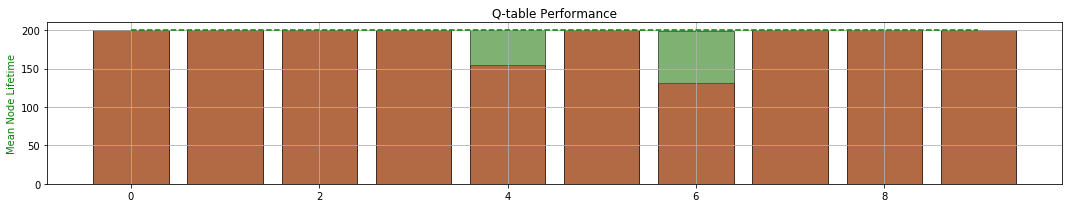

In [20]:
while iteration < MAX_NO_OF_ITERATIONS:

    print("\n")
    print("ITERATION #", iteration)
    tic = datetime.now()
    
    # MAP GYM ENVIRONMENT TO EACH PROCESS IN THE POOL
    ##################################################################
    iter_list = [iteration] * NO_OF_NODES
    arg_list = [arg for arg in zip(range(NO_OF_NODES), node_boundaries, iter_list, q_table_list)]
    result   = pool.starmap(mp_node_run, arg_list)
    ##################################################################
    
    # GATHER RESULTS
    ##################################################################
    node_boundaries = np.array([item[2] for item in result])
    node_time_rec   = np.array([item[1] for item in result])
    node_exp        = np.array([item[0] for item in result])
    
    all_exp         = np.array([item for each_node_exp in node_exp 
                                    for episode_exp in each_node_exp 
                                    for item in episode_exp]).reshape(-1,N_STATES*2+2)
    total_parallel_timesteps += node_time_rec.max()
    total_serial_timesteps   += node_time_rec.sum()
    EXP_GEN = node_time_rec.sum().astype(int)
    
    print("TOTAL EXPERIENCE GENERATED:   {:d}".format(EXP_GEN.astype(int)))

    print("SMALLEST TIMESTEP: {:d}".format(node_time_rec.min().astype(int)))
    print("LARGEST  TIMESTEP: {:d}".format(node_time_rec.max().astype(int)))

    print("TOTAL SERIAL TIMESTEPS:   {:d}".format(total_serial_timesteps.astype(int)))
    print("TOTAL PARALLEL TIMESTEPS: {:d}".format(total_parallel_timesteps.astype(int)))
    ##################################################################

    # PLOT EXPERIENCES
    ##################################################################
    node_avg_time = node_time_rec.mean(axis=1)
    node_std_time = node_time_rec.std(axis=1)
    node_max_time = node_time_rec.max(axis=1)
    node_min_time = node_time_rec.min(axis=1)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("Q-table Performance")
    ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

    ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
    ax2.set_ylabel('Mean Node Lifetime',color = 'g')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    if node_avg_time[node_avg_time >= 195].shape[0] > NO_OF_NODES/2:
        final_result = "SUCCESS"
        break

    # SEGREGATE AND STORE EXPERIENCES
    ##################################################################
    dqn.memory = np.insert(dqn.memory,0,all_exp,0)
    dqn.memory = dqn.memory[:MIN_MEMORY_CAP,:]
    dqn.memory_counter += all_exp.shape[0]
#     good_mem = all_exp[all_exp[:,N_STATES+1] == 1]    
#     bad_mem  = all_exp[all_exp[:,N_STATES+1] < 1]


#     dqn.good_memory = np.insert(dqn.good_memory, 0, good_mem , 0)
#     dqn.good_memory_counter += good_mem.shape[0]

#     dqn.bad_memory  = np.insert(dqn.bad_memory, 0, bad_mem , 0)
#     dqn.bad_memory_counter += bad_mem.shape[0]

#     dqn.good_memory = dqn.good_memory[:MIN_MEMORY_CAP,:]
#     dqn.bad_memory = dqn.bad_memory[:MIN_MEMORY_CAP,:]

    NN_ITERATIONS = MAX_NN_ITERATIONS
    print("MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.memory_counter))

#     print("GOOD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.good_memory_counter))
#     print("BAD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.bad_memory_counter))
    ##################################################################

    # LEARN
    ##################################################################
    print("Training Neural Network for", NN_ITERATIONS, "iterations", "@ LR = ", NN_LR)
    tic=datetime.now()
    nn_level_up_metric = 0
    for nn_iter in range(NN_ITERATIONS):
        dqn.learn()
        #validate by running for TIMESTEP_LIMIT iterations
        if(nn_iter%int(NN_ITERATIONS/5) == int(NN_ITERATIONS/5)-1):
            print("\nValidating... ",end="")
            time_rec = []
            v_env.length   = np.random.uniform(LENGTH_ABS_MIN, LENGTH_ABS_MAX)
            v_xtra = [v_env.length]
            for i_episode in range(TIMESTEP_LIMIT):
                time_step = 0
                s = v_env.reset()
                s = np.append(s, v_xtra)
                while True:
                    time_step += 1 
                    a = dqn.choose_greedy_action(s)
                    s_, r, done, info = v_env.step(a)
                    s_ = np.append(s_, v_xtra)
                    if done:
                        break
                    s = s_
                time_rec = np.append(time_rec, time_step)
            mean_time = time_rec.mean()
            print("MEAN TIME: ", mean_time)
            if mean_time >= nn_level_up_metric:
                nn_level_up_metric = mean_time
                nn_level_up_metric = clamp(0, nn_level_up_metric, 195)
                torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

    print("TRAINING TIME:{}".format(datetime.now()-tic))
    ##################################################################

    # CHECK PERFORMANCE OF THE BEST MODEL
    ##################################################################
    best_dqn = D3QN()
    best_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    best_dqn.eval_net.eval()

    time_rec = []
    for i_episode in range(TIMESTEP_LIMIT):
        env.length   = np.random.uniform(LENGTH_ABS_MIN, LENGTH_ABS_MAX)
        Xtra = [env.length]
        time_step = 0
        s = env.reset()
        s = np.append(s, Xtra)
        while True:
    #         env.render()
            time_step += 1 
            a = best_dqn.choose_greedy_action(s)
            s_, r, done, info = env.step(a)
            s_ = np.append(s_, Xtra)

            if done:
                break
            s = s_
        time_rec = np.append(time_rec, time_step)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.plot(data, color = 'm')
    ax2.plot(np.ones_like(data)*200, 'm--')
    ax2.set_title('Neural Network Performance using BEST MODEL ')
    ax2.set_ylabel('Time Steps',color = 'm')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    
    
        

    ##################################################################
    
    # CREATE INDIVIDUALIZED Q-TABLES FOR THE NODES
    ##################################################################
    if iteration >= 4:
        for node_id in range(NO_OF_NODES):
            # SET STATE VALUE BORDERS AS REQUESTED BY THE NODE
            ###############################################
            [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX,LENGTH_MAX,
             C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN,LENGTH_MIN]  = node_boundaries[node_id]
            ###############################################
            print(node_id,'-max-',node_boundaries[node_id][:N_STATES])
            print(node_id,'-min-',node_boundaries[node_id][N_STATES:])
            print("")

            # CREATE STATE COMBINATIONS
            ###############################################
            node_state_combinations = ndim_grid([C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN],
                                                [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX],
                                                [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN, LO_GRAIN*NO_OF_NODES])
            ###############################################
            start = timeit.default_timer()
            # GET Q-VALUES 
            %memit q_table_list[node_id] = best_dqn.get_greedy_action(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN, LO_GRAIN*NO_OF_NODES).astype(np.intp)
            stop = timeit.default_timer()
            print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
            #############################################################################################################################################

    else:
        for node_id in range(NO_OF_NODES):

            # PRINT STATE VALUE BORDERS AS REQUESTED BY THE NODE
            ###############################################
            [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
             C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = node_boundaries[node_id]
            ###############################################
            print(node_id,'-max-',node_boundaries[node_id][:N_STATES])
            print(node_id,'-min-',node_boundaries[node_id][N_STATES:])
            print("")
            #############################################################################################################################################
            node_state_combinations = init_state_combinations
            start = timeit.default_timer()
            # GET Q-VALUES 
            %memit q_table_list[node_id] = best_dqn.get_greedy_action(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN, LO_GRAIN*NO_OF_NODES).astype(np.intp)
            node_boundaries[node_id] = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX,LENGTH_ABS_MAX,
                                    C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN]
            stop = timeit.default_timer()
            print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
            #############################################################################################################################################

    iteration += 1
pool.close()
pool.join()

In [21]:
print("Total Parallel Timesteps : ", total_parallel_timesteps)
print("Total Serial Timesteps   : ", total_serial_timesteps)
print("Speed-up                 :  {:6.2f}".format(total_serial_timesteps/total_parallel_timesteps))

Total Parallel Timesteps :  1567.0
Total Serial Timesteps   :  1119521.0
Speed-up                 :  714.44


In [22]:
pool.close()
pool.join()
if iteration == MAX_NO_OF_ITERATIONS:
    final_result = "FAILURE"

In [23]:
print("{:6d} {} {:3d} {:3d} {:7d} {:10d} {:10.2f}".format(seed, final_result, int(node_min_time.min()), int(iteration), int(total_parallel_timesteps), int(total_serial_timesteps), total_serial_timesteps/total_parallel_timesteps))

   741 SUCCESS 131   8    1567    1119521     714.44
